In [1]:
import Labber
import numpy as np
import matplotlib.pyplot as plt
import os
from fitTools.utilities import Watt2dBm, dBm2Watt, VNA2dBm

In [2]:
datafile = r"G:\Shared drives\LFL\Labber\Data\2022\02\Data_0216\NBR07-8_JPAtuneup_sweepFluxAndPower.hdf5"

lf = Labber.LogFile(datafile)
sig = lf.getData(name = 'SA - Signal')

In [3]:
print(sig.shape)

(11025, 401)


In [4]:
datashape = (5,21,21,5,401)

sig = sig.reshape(datashape)

In [5]:
### linearize the spectrum analyzer data for averaging

linsig = dBm2Watt(sig)

### average the data, skipping the first trace of each point

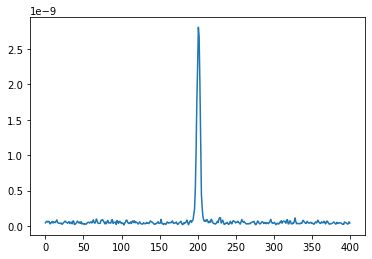

In [6]:
linsig = np.mean(linsig[:,:,:,1:,:],axis=-2)
plt.plot(linsig[0,0,0,:])

4272650000.0


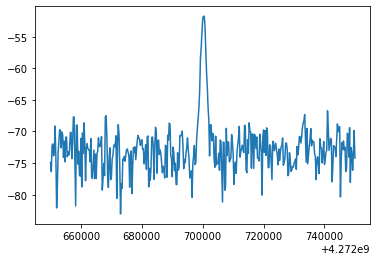

In [7]:
# Get the frequency data for spectrum analyzer sweeps
xdata,ydata = lf.getTraceXY(y_channel='SA - Signal')
plt.plot(xdata,ydata)
SAxdata = xdata

print(SAxdata[0])

# Now let's get the entries for power, freq, current

In [8]:
power = lf.getData(name = 'JPA pump - Power')
freq = lf.getData(name = 'JPA pump - Frequency')
flux = lf.getData(name = 'JPA flux - Source current')

print(power.shape)
print(freq.shape)
print(flux.shape)

(2205, 5)
(2205, 5)
(2205, 5)


In [9]:
power[0]

array([-6., -6., -6., -6., -6.])

In [10]:
power = power.reshape(datashape[:4])
power = power[0,0,:,0]
print(power)

[-6.   -5.75 -5.5  -5.25 -5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25
 -3.   -2.75 -2.5  -2.25 -2.   -1.75 -1.5  -1.25 -1.  ]


In [11]:
freq = freq.reshape(datashape[:4])
freq = freq[:,0,0,0]
print(freq)

[4.284e+09 4.285e+09 4.286e+09 4.287e+09 4.288e+09]


In [12]:
flux = flux.reshape(datashape[:4])
flux = flux[0,:,0,0]
print(flux)

[0.005   0.00501 0.00502 0.00503 0.00504 0.00505 0.00506 0.00507 0.00508
 0.00509 0.0051  0.00511 0.00512 0.00513 0.00514 0.00515 0.00516 0.00517
 0.00518 0.00519 0.0052 ]


# OK, now what we really care about is the SNR. Let's loop through each entry and calculate the SNR, max value of LO power, and the avg noise power using the spectrum analyzer data. 

In [13]:
SNR = np.empty(datashape[:3])
MAX = np.empty(datashape[:3])
NOISE = np.empty(datashape[:3])
for i in range(datashape[0]):
    for j in range(datashape[1]):
        for k in range(datashape[2]):
            max_ind=np.argmax(linsig[i,j,k])
            max_val=np.max(linsig[i,j,k])
            mask = np.logical_or(SAxdata < SAxdata[max_ind]-10e3, SAxdata > SAxdata[max_ind]+10e3)
            noise=linsig[i,j,k][mask]
            avg_noise=np.mean(noise)
            snr = Watt2dBm(max_val)-Watt2dBm(avg_noise)
            SNR[i,j,k] = snr
            MAX[i,j,k] = Watt2dBm(max_val)
            NOISE[i,j,k] = Watt2dBm(avg_noise)

In [14]:
print(np.max(SNR))
print(np.min(SNR))

28.278595959456702
4.493350717522532


In [15]:
max_ind = np.argmax(SNR)
ind3 = max_ind%datashape[2]
ind12 = max_ind//datashape[2]
ind2 = ind12%datashape[1]
ind1 = ind12//datashape[1]

max_ind = (ind1,ind2,ind3)
print(max_ind)

SNR[max_ind]

(2, 1, 11)


28.278595959456702

<ipython-input-16-d6064f2cefa4>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax[0].pcolormesh(XX, YY, SNR[max_ind[0]])
<ipython-input-16-d6064f2cefa4>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax[1].pcolormesh(XX, YY, NOISE[max_ind[0]])


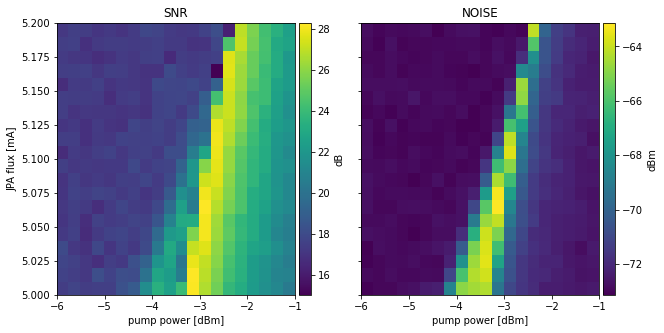

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

XX,YY = np.meshgrid(power,flux*1e3)

fig,ax = plt.subplots(1,2,sharey=True,figsize=[10,5])

im1 = ax[0].pcolormesh(XX, YY, SNR[max_ind[0]])
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical',label='dB')
ax[0].set_title('SNR')
ax[0].set_ylabel('JPA flux [mA]')
ax[0].set_xlabel('pump power [dBm]')
im2 = ax[1].pcolormesh(XX, YY, NOISE[max_ind[0]])
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical',label='dBm')
ax[1].set_title('NOISE')
ax[1].set_xlabel('pump power [dBm]')
plt.show()

In [17]:
import pickle

spath = r"G:\Shared drives\LFL\Projects\Quasiparticles\TestDataOptimization\\"
with open(spath+'SNR_broad.pkl','wb') as f:
    pickle.dump(SNR,f)
with open(spath+'power_broad.pkl','wb') as f:
    pickle.dump(power,f)
with open(spath+'flux_broad.pkl','wb') as f:
    pickle.dump(flux,f)

In [18]:
SNR.shape

(5, 21, 21)

<ipython-input-21-834018759ff0>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax[0].pcolormesh(XX, YY, SNR[i])
<ipython-input-21-834018759ff0>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax[1].pcolormesh(XX, YY, NOISE[i])


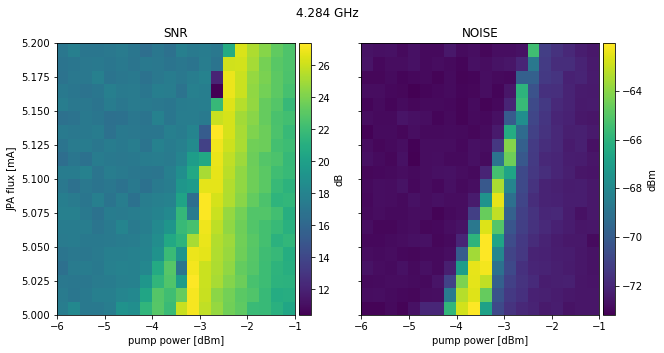

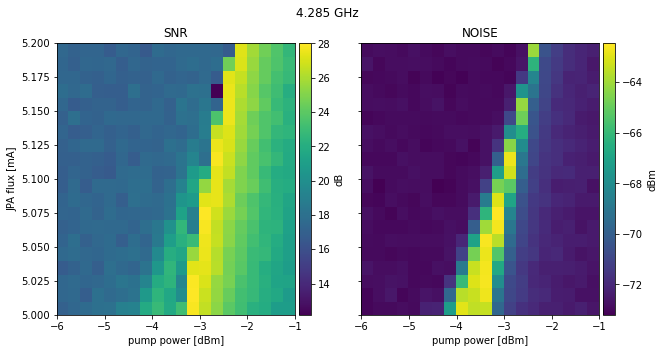

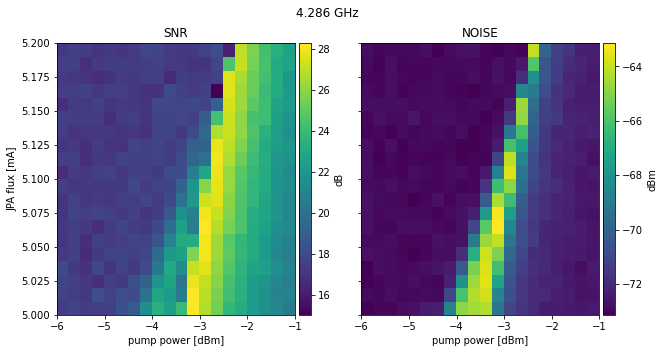

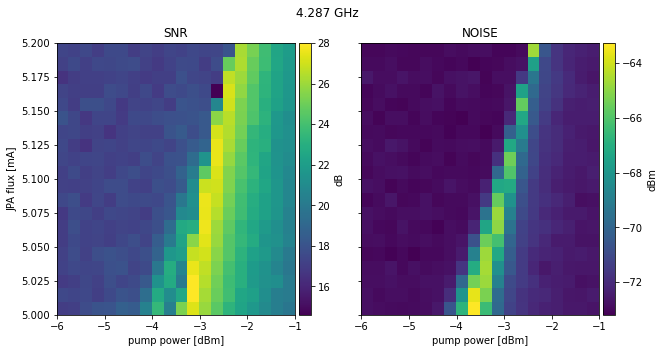

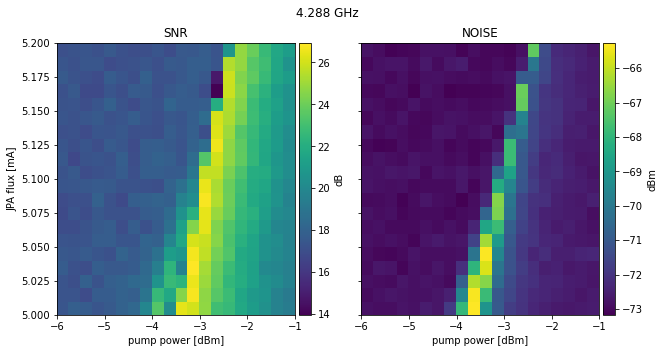

In [21]:
# Let's do the above plot for each frequency

XX,YY = np.meshgrid(power,flux*1e3)
for i,fl in enumerate(freq):
    fig,ax = plt.subplots(1,2,sharey=True,figsize=[10,5])
    fig.suptitle('{:.6} GHz'.format(fl*1e-9))
    im1 = ax[0].pcolormesh(XX, YY, SNR[i])
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical',label='dB')
    ax[0].set_title('SNR')
    ax[0].set_ylabel('JPA flux [mA]')
    ax[0].set_xlabel('pump power [dBm]')
    im2 = ax[1].pcolormesh(XX, YY, NOISE[i])
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical',label='dBm')
    ax[1].set_title('NOISE')
    ax[1].set_xlabel('pump power [dBm]')
    plt.show()

In [22]:
print(f'max SNR is at f = {freq[max_ind[0]]*1e-9}, flux = {flux[max_ind[1]]*1e3}, power = {power[max_ind[2]]}')

max SNR is at f = 4.2860000000000005, flux = 5.01, power = -3.25


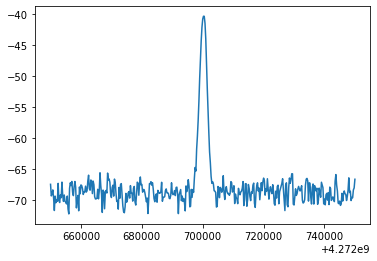

In [24]:
plt.plot(xdata,Watt2dBm(linsig[max_ind]))